In [1]:
import torch
import torch.nn as nn
import random
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt

seed = 0
torch.cuda.manual_seed_all(seed)
random.seed(seed)
torch.manual_seed(seed)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [2]:
img_size = 64

dataset = datasets.ImageFolder(root='Dataset',
                           transform = transforms.Compose([              
                               transforms.Resize(img_size),
                               transforms.CenterCrop(img_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))

In [3]:
batch_size = 128
num_channel = 3
dataloader = torch.utils.data.DataLoader(dataset, batch_size = batch_size, shuffle=True)

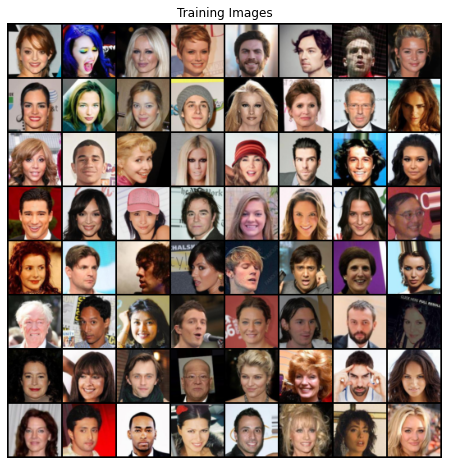

In [4]:
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(next(iter(dataloader))[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))
plt.show()

In [5]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.layers = nn.Sequential(
         nn.Conv2d(num_channel, num_fm_D, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(num_fm_D, num_fm_D * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(num_fm_D * 2),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(num_fm_D * 2, num_fm_D * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(num_fm_D * 4),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(num_fm_D * 4, num_fm_D * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(num_fm_D * 8),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(num_fm_D * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )
        self.layers.apply(weight_initialize)
    
    def forward(self, x):
        return self.layers(x)

In [6]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.layers = nn.Sequential(
            nn.ConvTranspose2d(dim_z, num_fm_G * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(num_fm_G * 8),
            nn.ReLU(True),

            nn.ConvTranspose2d(num_fm_G * 8, num_fm_G * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(num_fm_G * 4),
            nn.ReLU(True),

            nn.ConvTranspose2d(num_fm_G * 4, num_fm_G * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(num_fm_G * 2),
            nn.ReLU(True),

            nn.ConvTranspose2d(num_fm_G * 2, num_fm_G, 4, 2, 1, bias=False),
            nn.BatchNorm2d(num_fm_G),
            nn.ReLU(True),

            nn.ConvTranspose2d(num_fm_G, num_channel, 4, 2, 1, bias=False),
            nn.Tanh()
        )
        self.layers.apply(weight_initialize)
    
    def forward(self, x):
        return self.layers(x)

# Create generator and discriminator

The generator is comprised of convolutional-transpose layers, batch norm layers, and ReLU activations.

The discriminator consists of Conv2d, BatchNorm2d, and LeakyReLU layers, and outputs the final probability through a Sigmoid activation function.

## Initialize model weights

This function is applied to the models immediately after initialization.

In [7]:
def weight_initialize(model):
    classname = model.__class__.__name__
    
    if classname.find('Conv') != -1:
        nn.init.normal_(model.weight.data, 0.0, 0.02)
        
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(model.weight.data, 1.0, 0.02)
        nn.init.constant_(model.bias.data, 0)

In [8]:
dim_z = 100
num_fm_D = num_fm_G = 64

In [9]:
G = Generator().to(device)
D = Discriminator().to(device)

# Train DCGAN

In [10]:
criterion = nn.BCELoss()
lr, beta = 2e-4, 0.5
validation_noise = torch.randn(64, dim_z, 1, 1, device=device)
optimizer_D = optim.Adam(D.parameters(), lr=lr, betas=(beta, 0.999))
optimizer_G = optim.Adam(G.parameters(), lr=lr, betas=(beta, 0.999))

In [11]:
NUM_EPOCH = 30
img_list = []
Loss_G = []
Loss_D = []
iteration = 0

for epoch in range(1, NUM_EPOCH + 1):
    for i, (img, label) in enumerate(dataloader):
        D.zero_grad()
        img = img.to(device)
        output = D(img).view(-1)
        errD = criterion(output, torch.ones((img.size(0),), dtype = torch.float, device = device))        
        Dx = output.mean().item()
        
        noise = torch.randn(img.size(0), dim_z, 1, 1, device = device)
        img_fake = G(noise)

        output = D(img_fake.detach()).view(-1)
        errD += criterion(output, torch.zeros((img.size(0),), dtype = torch.float, device = device))

        D_G_z1 = output.mean().item()

        errD.backward()
        optimizer_D.step()
        
        G.zero_grad()
        output = D(img_fake).view(-1)
        errG = criterion(output, torch.ones((img.size(0),), dtype = torch.float, device = device))
        errG.backward()
        D_G_z2 = output.mean().item()
        optimizer_G.step()
                
        Loss_D.append(errD.item())
        Loss_G.append(errG.item())

        if i % 500 == 0:
            print(f'[{epoch}/{NUM_EPOCH}]|[{i + 1}/{len(dataloader)}] - \n loss(D) : {errD.item()}, D(x): {Dx:.4f} \n loss(G) : {errG.item()} \t, D(G(z)): {D_G_z1:.4f} / {D_G_z2:.4f}')
            
    if (epoch == 5) or (epoch == 15) or (epoch == 25) or (epoch == NUM_EPOCH):
        with torch.no_grad():
            fake = G(validation_noise).detach().cpu()
        img_list.append((f'Epoch {epoch}' ,vutils.make_grid(fake, padding = 2, normalize=True)))

[1/30]|[1/1583] - 
 loss(D) : 2.2235019207000732, D(x): 0.7894 
 loss(G) : 6.309937477111816 	, D(G(z)): 0.8133 / 0.0032
[1/30]|[501/1583] - 
 loss(D) : 0.5425296425819397, D(x): 0.8500 
 loss(G) : 3.5713918209075928 	, D(G(z)): 0.1849 / 0.0441
[1/30]|[1001/1583] - 
 loss(D) : 0.45661091804504395, D(x): 0.7640 
 loss(G) : 3.8571600914001465 	, D(G(z)): 0.0633 / 0.0356
[1/30]|[1501/1583] - 
 loss(D) : 0.5060242414474487, D(x): 0.8516 
 loss(G) : 3.7483131885528564 	, D(G(z)): 0.2390 / 0.0401
[2/30]|[1/1583] - 
 loss(D) : 0.3587464690208435, D(x): 0.8389 
 loss(G) : 3.35563063621521 	, D(G(z)): 0.1287 / 0.0497
[2/30]|[501/1583] - 
 loss(D) : 2.6557228565216064, D(x): 0.9700 
 loss(G) : 9.016855239868164 	, D(G(z)): 0.8485 / 0.0003
[2/30]|[1001/1583] - 
 loss(D) : 0.5501662492752075, D(x): 0.8721 
 loss(G) : 3.4403114318847656 	, D(G(z)): 0.2946 / 0.0476
[2/30]|[1501/1583] - 
 loss(D) : 0.39091619849205017, D(x): 0.7725 
 loss(G) : 2.754300117492676 	, D(G(z)): 0.0855 / 0.0871
[3/30]|[1/1

[17/30]|[1501/1583] - 
 loss(D) : 0.09859926998615265, D(x): 0.9710 
 loss(G) : 5.100381374359131 	, D(G(z)): 0.0620 / 0.0120
[18/30]|[1/1583] - 
 loss(D) : 0.045671023428440094, D(x): 0.9743 
 loss(G) : 5.29664421081543 	, D(G(z)): 0.0180 / 0.0113
[18/30]|[501/1583] - 
 loss(D) : 0.2262977808713913, D(x): 0.8328 
 loss(G) : 4.065181732177734 	, D(G(z)): 0.0189 / 0.0378
[18/30]|[1001/1583] - 
 loss(D) : 4.8555450439453125, D(x): 0.0192 
 loss(G) : 0.04954378306865692 	, D(G(z)): 0.0032 / 0.9575
[18/30]|[1501/1583] - 
 loss(D) : 0.2339099496603012, D(x): 0.8447 
 loss(G) : 4.07258415222168 	, D(G(z)): 0.0400 / 0.0339
[19/30]|[1/1583] - 
 loss(D) : 0.10381126403808594, D(x): 0.9791 
 loss(G) : 5.322083473205566 	, D(G(z)): 0.0713 / 0.0088
[19/30]|[501/1583] - 
 loss(D) : 0.08758629858493805, D(x): 0.9439 
 loss(G) : 4.79234504699707 	, D(G(z)): 0.0248 / 0.0194
[19/30]|[1001/1583] - 
 loss(D) : 0.8950297832489014, D(x): 0.5290 
 loss(G) : 1.9204455614089966 	, D(G(z)): 0.0125 / 0.2352
[19

# 1. Construct a DCGAN with GAN objective

In the homework, we implement the DCGAN by the setting and architecture suggested by the paper since GAN is known to be unstable to train. Besides, in the paper, since the model is used to train three different large-scale data sets, the model should be sufficient for us to train the CelebA data sets.

(a) Describe how you preprocess the dataset (such as resize, crop, rotate and flip) and explain why.

Since our dataset is large and complicated enough, we only resize the images and crop them from the center. Besides, we didn't do rotation because it may becomes a noise which makes the results worse. And we try to flip the data, but the results became odd. Therefore, we only perform resizing and cropping at the end.

(b) Plot the learning curves for both generator and discriminator.

We record the error of every iteration and plot it. The blue line is the loss for the generator while the other one is for the discriminator.

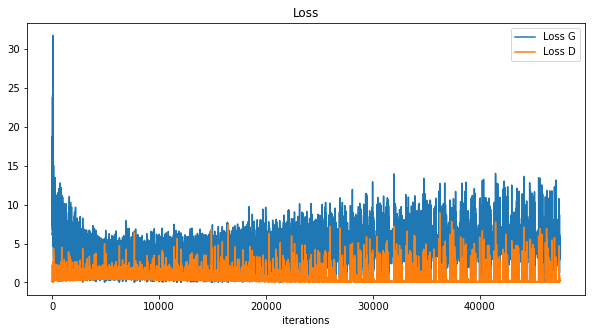

In [12]:
plt.figure(figsize=(10,5))
plt.title("Loss")
plt.plot(Loss_G,label="Loss G")
plt.plot(Loss_D,label="Loss D")
plt.xlabel("iterations")
# plt.ylabel("Loss")
plt.legend()
plt.savefig('Loss.png')
plt.show()

(c) Draw some samples generated from your generator at different training stages. For example, you may show the results when running at 5th and final learning iteration.

We record images generated from same noise at different stages. As we can see, at the stage of epoch 5, lots of images look blurry, followed by that images at epoch 10 became clearer. Take the one in the first row at the second from the right for example, the outline of the face is sharper than that at epoch 5. At epoch 25, the facial features are more pronounced. At epoch 30 which is the last epoch, the one in the bottom row at the second from the right becomes closer to the real person. In general, the images at the last epoch are harder to distinguish from the real ones. For example, there is a person ending up wearing glasses.

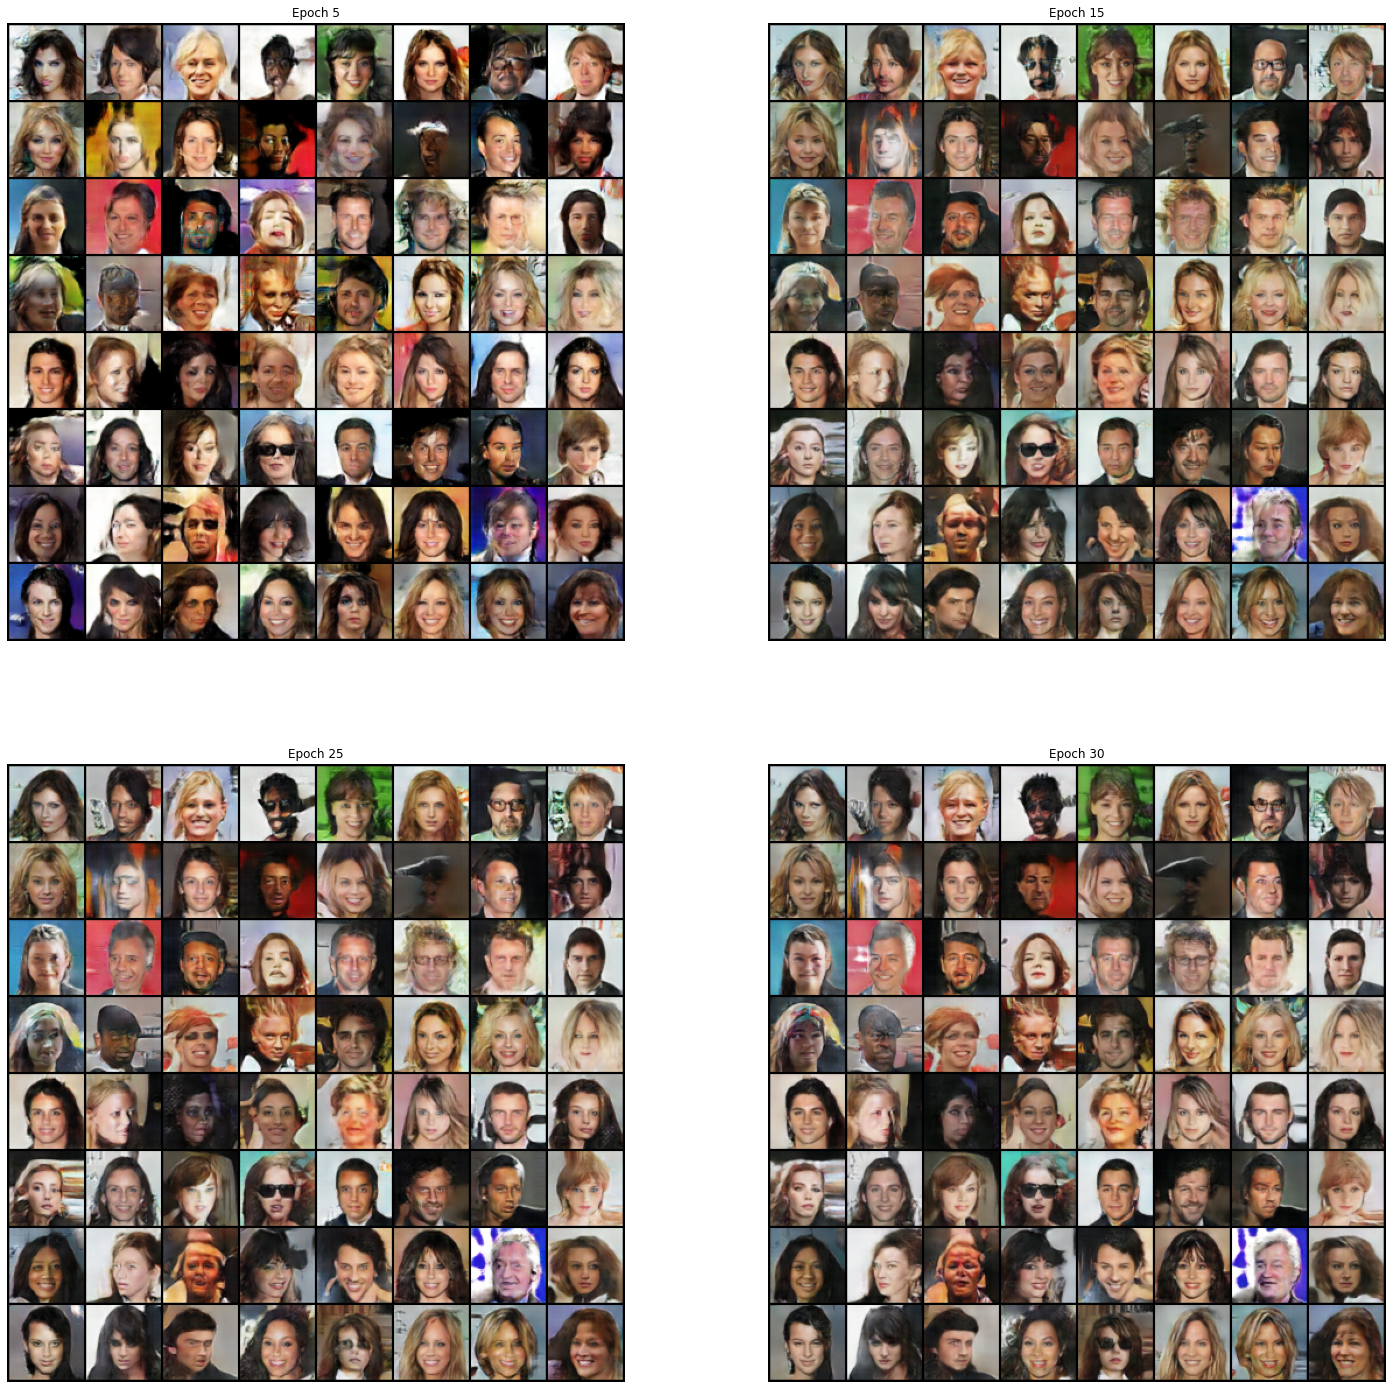

In [13]:
fig = plt.figure(figsize=(25, 25))

for i, (title, img) in enumerate(img_list):
    plt.subplot(len(img_list)//2, 2, i + 1)
    plt.axis("off")
    plt.title(title)
    plt.imshow(np.transpose(img,(1,2,0)))
plt.savefig('DCGAN_comparison.png')
plt.show()

# 2. Please answer the following questions

#### (a) Please describe the meaning of the following four pictures during training of GAN, where blue dashed line indicates the discriminator, green solid line indicates the generator. The answer should include the following: (Note: Each step should be discussed.)

− what is the meaning of black dashed line, x and z

− which step is to train the generator or discriminator and show the corresponding
objective function

− why D(x) equals to 1/2 in ideal case when the training is finished

=====================================================

i. Meaning of x and z:

The black dashed line is the distribution of samples from training data $(p_{x})$;

x is the sample space and z is the latent space.

ii. 

G: generator, D: discriminator

The blue line is the distribution for discriminator and the green one is that for generator. 

Step (A): Consider a pair near convergence: $p_{g}$ would be similar to $p_{data}$. At this point, D can partially successful in classifying the images.

Step (B): In the step, D is trained to discirminate samples from data and the objective function is $E[log D(x)]$.

Step (C): We train G in the step by maximizing $logD(G(z))$ (i.e. minimize $E[log(1-D(G(z)))]$). By doing so, G would generate data that are more likely to classified as true images.

Step (D): In this stage, GAN would achieve the equilibrium where G and D are well-trained, that is, $p_{g} = p_{data}$. At this point, D is unable to distinguish the images from G from the real ones.

iii. 

The reason why D(x) is 1/2 in ideal case is that the equilibrium of GAN is when the generator generate fake images that look like exactly from the training data and the discriminator can only guess at 50% confidence that the images is real or fake.

#### (b) The Helvetica Scenario often happens during training procedure of GAN. Please explain why this problem occurs and how to avoid it.

If the discriminator stucks in a local minimum and can't distinguish between a real input and the output of generator, the generator would tend to generating the same output or at most slightly different ones, that is, the generator map all noise input values to a single region without learning to generate other distinct samples. It would result in the low diversity for the generated images or even the same identical image.

=====================================================

To avoid it:

(1) The generator must not be trained too much without updating the discriminator.

(2) Training GAN with diverse samples of data (i.e. using mini-batch)

(3) Unrolling: update the generator loss function not only based on current discriminator’s classifications, but also the outputs of k future discriminator results. Therefore, the generator won't over-optimize for current discriminator.

(4) Use different loss function such as Wasserstein loss, which is designed to address this problem.

#### (c) Both VAE and GAN are generative models. The following figures are random generated results by using VAE (left) and GAN (right). Please compare two results and describe the pros and cons of two models. 

Both of them are generative models, which means they learn a given data distribution rather than its density. The difference between these two models is how they learn. GAN try to find an equilibrium between the generator and the discriminator whereas VAE encode the training data to a low-dimensional representation and learn the data distribution.

=====================================================

The architecture and loss function of models: 

GAN has two components in its architecture, which consists of generator and discriminator. Its generator generates fake images that could fool the discriminator and its discriminator tries to distinguish fake images from real ones. On the other hand, VAE has encoder and decoder in its architecture. The encoder encodes the data into latent vector followed by the decoder sampling from the distribution of latent vector to obtain an input and decode it. The key difference between VAE and GAN is that the hidden state distributions of VAE are predefined and it aims to minimize the reconstruction error. When using GAN, it is a competition between generator and discriminator. The generator aims at minimizing the difference between P(X) and P(Z|Y) where X is a real sample and the discriminator aims to correctly classify the real images based on the term D(x) in the loss function.

=====================================================

Besides, other characteristics are:

(1) Markov chains are never needed and GAN is only updated with gradients.

(2) GAN generally have better results but it is hard to train.

(3) VAE is easier to train but sometimes the results are blurry.

(4) A well-trained GAN can generate the data that is indistinguishable from real data.

(5) It’s hard for GAN to learn to generate discrete data such as text.